<a href="https://colab.research.google.com/github/docmhvr/Deep_Learning_with_Pytorch/blob/main/Deep%20Learning%20on%20MNIST%20with%20Pytorch/Image_classification_Using_MLP_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">MNIST Digit Classification using PyTorch</h1>

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_week2_MNIST_Digits.png' width=650 align='center'>



We shall first begin with our imports.

In [1]:
import os
import time
import random
import numpy as np

from dataclasses import dataclass
from typing import List, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sn

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['image.cmap'] = 'gray'

In [2]:
bold = f"\033[1m"
reset = f"\033[0m"

We need to set the required seeds to make the results **reproducible**.

In [3]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. Default is 42.
        package_list (str): String containing a list of additional packages to install
        for Google Colab or Kaggle. Default is None.

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ

    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for the availability GPUs.
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}

        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True

        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)

    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False

        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')

        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [4]:
# Additional packages required for Google Colab or Kaggle.
package_list = "torchinfo"

DEVICE, GPU_AVAILABLE = system_config(package_list=package_list)

Using CUDA GPU
Installing required packages...
Device:  cuda


In [5]:
from torchinfo import summary

## Training Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    BATCH_SIZE:  int = 32
    NUM_WORKERS: int = 2
    DATA_ROOT:   str = "./DATA_MNIST"

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 6
    LEARNING_RATE:  float = .01

## Data Loading

In [7]:
def get_data(root_dir, batch_size, num_workers=1):

    preprocess_transforms = T.Compose([
                                # Convert (H,W,C) to (C,H,W) and normalize data to [0., 1.].
                                # by dividing with 255.
                                T.ToTensor(),
                                # Subtract mean (0.1307) and divide by variance (0.3081).
                                # This mean and variance is calculated on training data.
                                T.Normalize(mean=[.1307,], std=[.3081,])
                             ])

    # Training set
    train_dataset = datasets.MNIST(root_dir,
                                   train=True,
                                   download=True,
                                   transform=preprocess_transforms)

    # Validation dataset
    validation_dataset = datasets.MNIST(root_dir,
                                        train=False,
                                        transform=preprocess_transforms)

    # Train DataLoader
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)
    # Validation DataLoader
    validation_loader = DataLoader(dataset=validation_dataset,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=num_workers)

    return train_loader, validation_loader

### Data Visualization

Let us now display a sample from the train data. We will initialize the `image_size`, `batch_size`, the dataset directory, and the workers here.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5242834.12it/s]


Extracting ./DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 154081.57it/s]


Extracting ./DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1447969.41it/s]


Extracting ./DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11173330.66it/s]

Extracting ./DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DATA_MNIST/MNIST/raw



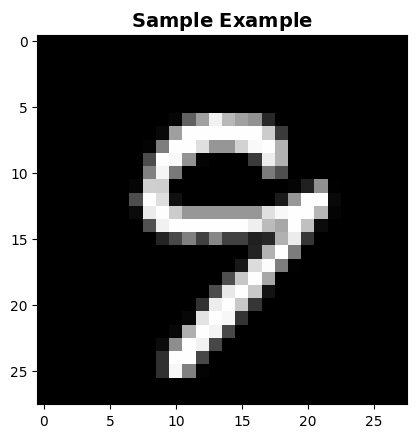

In [8]:
data_config = DatasetConfig()

train_loader, _ = get_data(
                    root_dir=data_config.DATA_ROOT,
                    batch_size=data_config.BATCH_SIZE,
                    num_workers=data_config.NUM_WORKERS)

image_batch, _ = next(iter(train_loader))

rand_idx = random.choice(range(len(image_batch)))

plt.imshow(image_batch[rand_idx].squeeze())
plt.title(r"$\bf{Sample\ Example}$", fontsize=14)
plt.show()

### Model Architecture Definition

To transform the image data into a set of features, we need to flatten the 2D array into a 1D array. The `28x28` input image thus becomes a 1D array containing `784` features.

In [9]:
class SingleLayerPerceptron(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.linear = nn.Linear(in_features=28*28, out_features=self.num_classes)

    # Forward pass.
    def forward(self,x):
        # Flatten the `(B, 1, 28, 28)` tensor to `(B, 784)` features.
        # for the Linear layer.
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

## Training Pipeline

In [10]:
def train(DEVICE: torch.device,
          model: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch_idx: int,
         ) -> Tuple[float, float]:

    # Specify training mode for model.
    model.train()
    # Send to device.
    model.to(DEVICE)

    step_loss = 0
    step_accuracy = 0

    for data, target in train_loader:

        # Send data and target to appropriate device.
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Convert logits to probabilty scores.
        prob = output.detach().softmax(dim=1)

        # Get the index of the max probability.
        pred_idx = prob.argmax(dim=1)

        # Batch Loss.
        step_loss+= loss.item() * data.shape[0]

        # Batch accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()


    epoch_loss = float(step_loss / len(train_loader.dataset))
    epoch_acc = float(step_accuracy/ len(train_loader.dataset))

    print(f"{f'{bold}[ Epoch: {epoch_idx} ]{reset}':=^80}")

    train_loss_stat = f"{bold}Train Loss: {epoch_loss:.4f}{reset}"
    train_acc_stat = f"{bold}Train Acc: {epoch_acc:.4f}{reset}"

    print(f"\n{train_loss_stat:<30}{train_acc_stat}")

    return epoch_loss, epoch_acc

### Define Validation Step

We use the validation loader to pass batches of data through the network for performing validation on unseen data.

Note that there is only forward pass and no backward pass during validation.

In [11]:
def validate(
    DEVICE: torch.device,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:

    # Enable model in evaluation mode.
    model.eval()
    model.to(DEVICE)

    step_loss = 0
    step_accuracy = 0

    for data, target in test_loader:

        # Send data and target to appropriate device.
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        test_loss = F.cross_entropy(output, target).item()

        # Convert model's logits to probability scores.
        prob = output.softmax(dim=1)

        # Get the class id for the maximum score.
        pred_idx = prob.argmax(dim=1)

        # Batch validation loss.
        step_loss+= test_loss * data.shape[0]

        # Batch validation accuracy.
        step_accuracy+= (pred_idx.cpu() == target.cpu()).sum()

    test_loss = float(step_loss / len(test_loader.dataset))
    test_acc = float(step_accuracy/ len(test_loader.dataset))

    valid_loss_stat = f"{bold}Valid Loss: {test_loss:.4f}{reset}"
    valid_acc_stat = f"{bold}Valid Acc: {test_acc:.4f}{reset}"

    print(f"\n{valid_loss_stat:<30}{valid_acc_stat}")

    return test_loss, test_acc

### Train the Model

Now, lets create our model. We instantiate the model using the `SingleLayerPerceptron` class. We shall also print its summary. We have used `SGD` as our choice of optimizer.

In [12]:
train_config = TrainingConfig()
dataset_config = DatasetConfig()

# Training parameters.
num_epochs = train_config.EPOCHS

# Construct the model.
model = SingleLayerPerceptron(num_classes=data_config.NUM_CLASSES)

# Print Model summary.
print(summary(model,
              input_size=(1, 1, 28, 28),
              row_settings=["var_names"]))

# Define the optimizer.
optimizer = optim.SGD(model.parameters(), lr=train_config.LEARNING_RATE)

Layer (type (var_name))                            Output Shape              Param #
SingleLayerPerceptron (SingleLayerPerceptron)      [1, 10]                   --
├─Linear (linear)                                  [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03


We keep track of the loss and accuracies of each epoch so that we can plot it to visualize the progressive change in loss and accuracy over epochs.

In [13]:
train_loss_history = []
train_acc_history  = []

valid_loss_history = []
valid_acc_history  = []

# Get train and valididation dataloaders.
train_loader, valid_loader = get_data(root_dir=dataset_config.DATA_ROOT,
                                      batch_size=dataset_config.BATCH_SIZE,
                                      num_workers=dataset_config.NUM_WORKERS
                                     )
# Trainig time measurement
t_begin = time.time()
for epoch in range(num_epochs):

    train_loss, train_acc = train(DEVICE, model,optimizer, train_loader, epoch+1)
    valid_loss, valid_acc = validate(DEVICE, model, valid_loader)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)


print(f"Total time: {(time.time() - t_begin):.2f}s")

==============================[ Epoch: 1 ]==============================

Train Loss: 0.4078    Train Acc: 0.8869

Valid Loss: 0.3083    Valid Acc: 0.9131
==============================[ Epoch: 2 ]==============================

Train Loss: 0.3110    Train Acc: 0.9121

Valid Loss: 0.2908    Valid Acc: 0.9183
==============================[ Epoch: 3 ]==============================

Train Loss: 0.2957    Train Acc: 0.9161

Valid Loss: 0.2847    Valid Acc: 0.9193
==============================[ Epoch: 4 ]==============================

Train Loss: 0.2869    Train Acc: 0.9194

Valid Loss: 0.2814    Valid Acc: 0.9213
==============================[ Epoch: 5 ]==============================

Train Loss: 0.2808    Train Acc: 0.9208

Valid Loss: 0.2763    Valid Acc: 0.9210
==============================[ Epoch: 6 ]==============================

Train Loss: 0.2769    Train Acc: 0.9227

Valid Loss: 0.2807    Valid Acc: 0.9204
Total time: 106.61s


### Plot the Loss & Accuracy curves

In [14]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

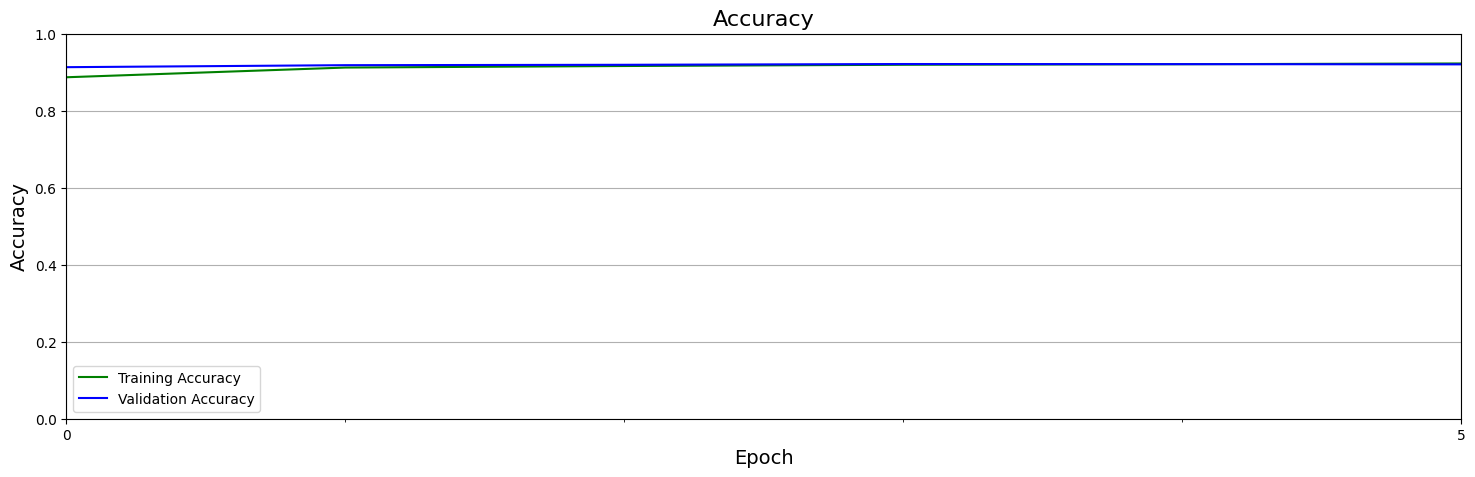

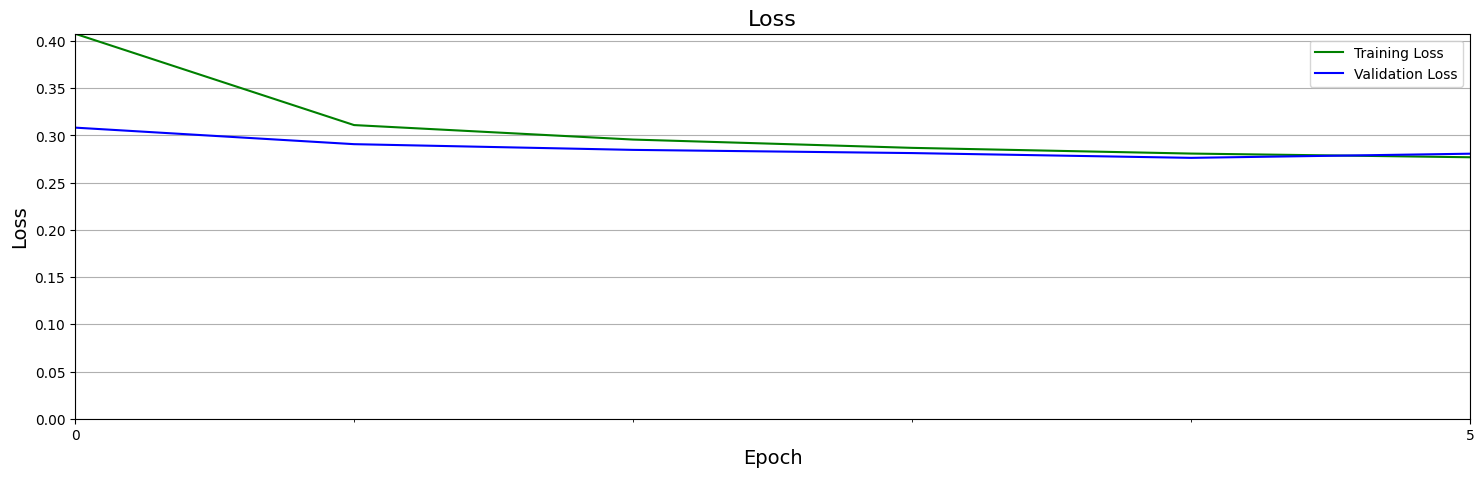

In [15]:
# Retrieve training results.
train_loss = train_loss_history
train_acc  = train_acc_history
valid_loss = valid_loss_history
valid_acc  = valid_acc_history

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## Multi Layer Perceptron

In [16]:
# Define the model
class MLP(torch.nn.Module):
    def __init__(self, num_classes):
        # Initialize super class
        super().__init__()

        self.num_clasees = num_classes

        # Build model using Sequential container
        self.classifier = nn.Sequential(
                            # Add input layer
                            nn.Linear(in_features=28*28, out_features=512),
                            # Add ReLU activation
                            nn.ReLU(),
                            # Add Another layer
                            nn.Linear(in_features=512, out_features=512),
                            # Add ReLU activation
                            nn.ReLU(),
                            # Add Output layer
                            nn.Linear(in_features=512, out_features=self.num_clasees)
                        )

    # Forward Pass.
    def forward(self, x):
        # Flatten the `(B, 1, 28, 28)` tensor to `(B, 784)` fetaures
        # for the Linear layer.
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

### 6.2 Train the Model

We instantiate the model using the `MLP` class and print its summary. We have used the `SGD` optimizer here as well.

In [17]:
train_config = TrainingConfig()
dataset_config = DatasetConfig()

# Training parameters.
num_epochs = train_config.EPOCHS

# Construct the model.
model_mlp = MLP(num_classes=data_config.NUM_CLASSES)

# Print Model summary.
print(summary(model_mlp,
              input_size=(1, 1, 28, 28),
              row_settings=["var_names"]))

# Define the optimizer.
optimizer = optim.SGD(model_mlp.parameters(), lr=train_config.LEARNING_RATE)

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Sequential (classifier)                [1, 10]                   --
│    └─Linear (0)                        [1, 512]                  401,920
│    └─ReLU (1)                          [1, 512]                  --
│    └─Linear (2)                        [1, 512]                  262,656
│    └─ReLU (3)                          [1, 512]                  --
│    └─Linear (4)                        [1, 10]                   5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.68
Estimated Total Size (MB): 2.69


We keep track of the loss and accuracies use the lists: `train_loss_history`, `train_acc_history`, `val_loss_history`, and `val_acc_history`.

In [18]:
train_loss_history = []
train_acc_history  = []

valid_loss_history = []
valid_acc_history  = []

# trainig time measurement
t_begin = time.time()
for epoch in range(num_epochs):

    train_loss, train_acc = train(DEVICE, model_mlp, optimizer, train_loader, epoch+1)
    valid_loss, valid_acc = validate(DEVICE, model_mlp, valid_loader)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

print(f"Total time: {(time.time() - t_begin):.2f}s")

==============================[ Epoch: 1 ]==============================

Train Loss: 0.5093    Train Acc: 0.8666

Valid Loss: 0.2518    Valid Acc: 0.9290
==============================[ Epoch: 2 ]==============================

Train Loss: 0.2246    Train Acc: 0.9350

Valid Loss: 0.1847    Valid Acc: 0.9456
==============================[ Epoch: 3 ]==============================

Train Loss: 0.1655    Train Acc: 0.9517

Valid Loss: 0.1454    Valid Acc: 0.9562
==============================[ Epoch: 4 ]==============================

Train Loss: 0.1297    Train Acc: 0.9628

Valid Loss: 0.1188    Valid Acc: 0.9654
==============================[ Epoch: 5 ]==============================

Train Loss: 0.1065    Train Acc: 0.9693

Valid Loss: 0.1054    Valid Acc: 0.9682
==============================[ Epoch: 6 ]==============================

Train Loss: 0.0890    Train Acc: 0.9747

Valid Loss: 0.0943    Valid Acc: 0.9717
Total time: 116.42s


### 6.3 Plot the Loss & Accuracy curves

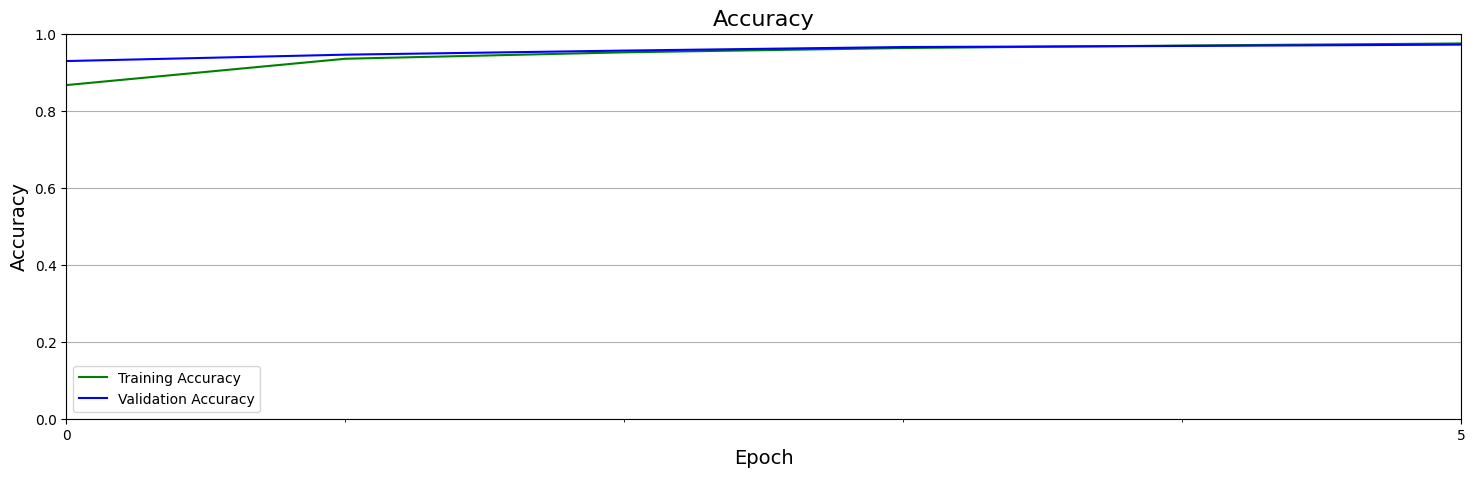

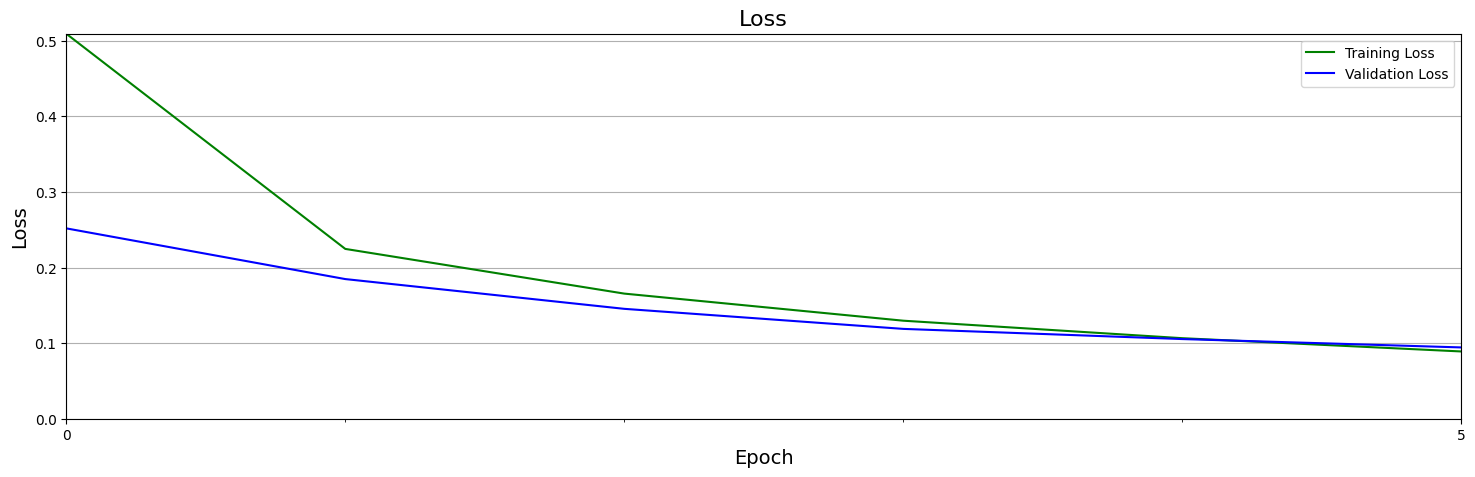

In [19]:
# Retrieve training results.
train_loss = train_loss_history
train_acc  = train_acc_history
valid_loss = valid_loss_history
valid_acc  = valid_acc_history

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## Model Evaluation

### Make Predictions on a Sample Test Image

We can now predict the results for all the test images. We select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

First, we get the next batch from the validation loader. Then we plot the image

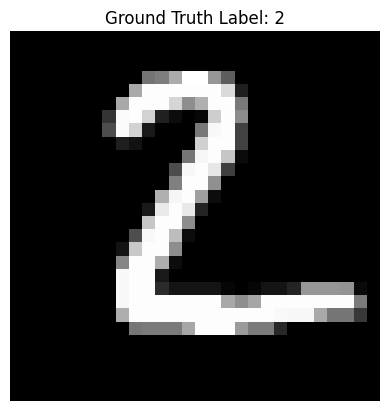

In [20]:
image_sample, labels_sample = next(iter(valid_loader))

rand_idx = random.choice(range(len(image_batch)))

plt.imshow(image_sample[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(labels_sample[rand_idx])), fontsize=12)
plt.axis("off")
plt.show()

In [21]:
model_mlp.eval()

with torch.no_grad():
    batch_outputs = model_mlp(image_sample.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print('Predictions for each class on test image:\n')

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx==pred_cls_id:
        print(f"{bold}Digit: {idx}, Probability: {cls_prob:.3f}{reset}")
    else:
        print(f"Digit: {idx}, Probability: {cls_prob:.3f}")

Predictions for each class on test image:

Digit: 0, Probability: 0.000
Digit: 1, Probability: 0.001
Digit: 2, Probability: 0.991
Digit: 3, Probability: 0.007
Digit: 4, Probability: 0.000
Digit: 5, Probability: 0.000
Digit: 6, Probability: 0.000
Digit: 7, Probability: 0.000
Digit: 8, Probability: 0.000
Digit: 9, Probability: 0.000


### Confusion Matrix

We need to collect validation ground truth labels and obtain the predictions of the samples across the entire validation data to pass it through the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.

The `prediction_batch` function takes in the trained model and the image batch and returns the class index having the highest logits.

In [22]:
def prediction_batch(model: nn.Module, batch_inputs: torch.tensor):

    model.eval()

    batch_ops = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_ops.softmax(dim=1)

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

We obtain the predicted class labels for each batch sample and finally concatenate the predictions and the ground truth samples across the entire validation data.

In [23]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in valid_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(model_mlp, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)


val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

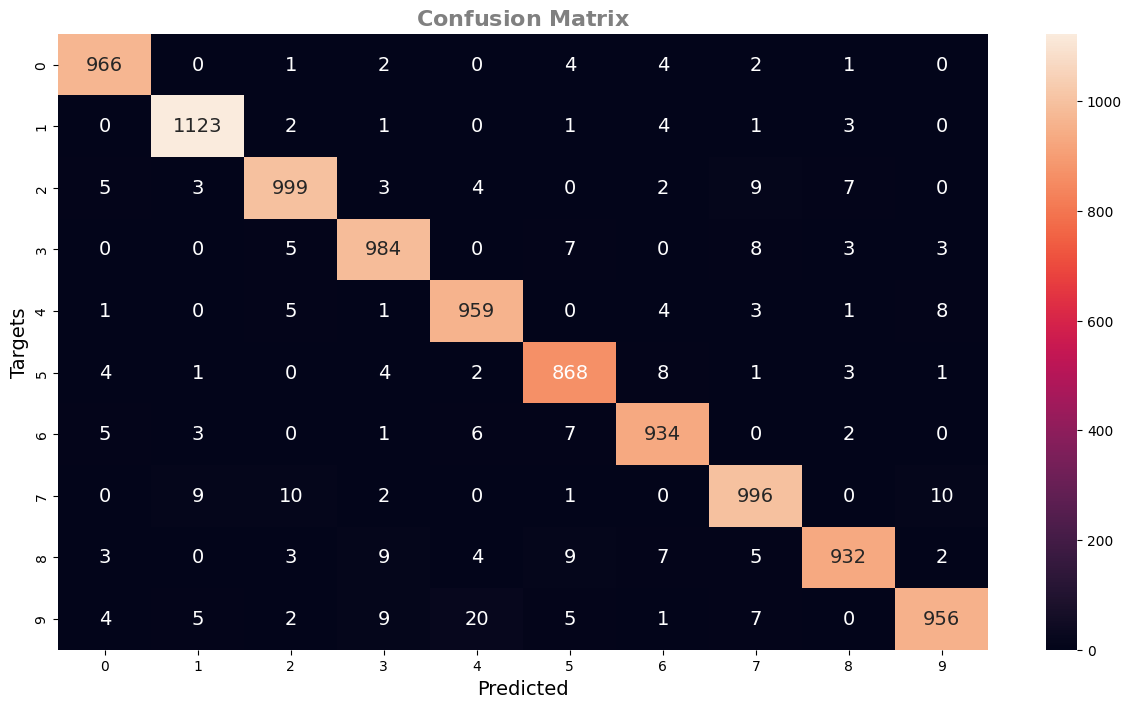

In [24]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)

plt.figure(figsize=[15, 8])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(r"$\bf{Confusion\ Matrix}$", color="gray")
plt.show()

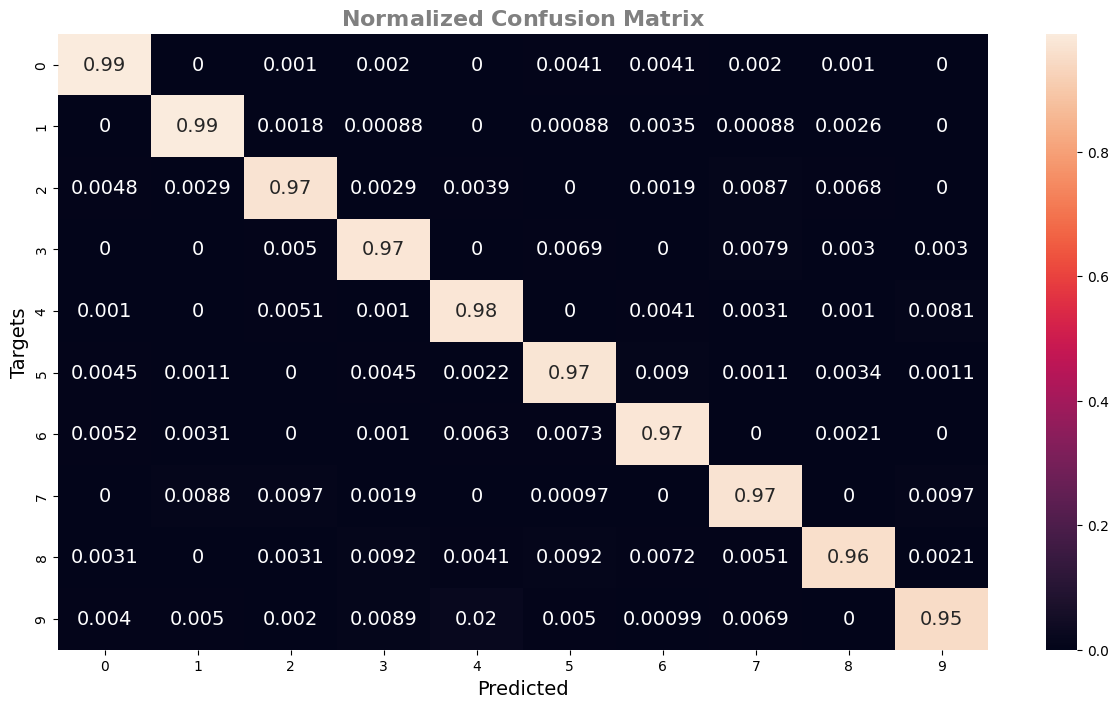

In [25]:
cm_norm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels, normalize="true")

plt.figure(figsize=[15, 8])
sn.heatmap(cm_norm, annot=True, annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(r"$\bf{Normalized\ Confusion\ Matrix}$", color="gray")
plt.show()

## 8 Conclusions

In this notebook, we introduced multinomial classification, which is an extension to binary classification that uses the softmax activation function. We also introduced one (simple) approach for how to preprocess image data for use in a neural network. In the next module we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well known CNN architectures, which is a great place to start getting familiar with them.

https://tensorspace.org/html/playground/lenet.html